In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
# random.seed(0)

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [3]:
imheight = 28
imwidth = 28
channels = 1
# ALPHA = 0.2
ALPHA=0.2

In [4]:
# shared Layer 
shared_Conv1= Conv2D(32, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [5]:
def create_embNet():
    some_input = Input(shape=(imwidth, imheight, channels))
    conv1 = shared_Conv1(some_input)
    pool1 = shared_MP1(conv1)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    flatten = Flatten()(pool2)
    dense_layer = Dense(2, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return Model(inputs=[some_input], outputs=norm_layer)

In [6]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [7]:
# for embedding
embNet_a = create_embNet()
embNet_p = create_embNet()
embNet_n = create_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

In [8]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

## -----------------------------------------------------------------------------------------
## make triplet with mnist dataset

In [14]:
from keras.datasets import mnist
from keras.utils import np_utils

# load mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Reshape mnist data from (60000,28,28) to (60000,28,28,1)

In [15]:
if K.image_data_format() == 'channels_first': # Theano backend
    X_train = X_train.reshape(X_train.shape[0], 1, imwidth, imheight)
    X_test = X_test.reshape(X_test.shape[0], 1, imwidth, imheight)
    input_shape = (1, imwidth, imheight)
else:                                         # Tensorflow backend
    X_train = X_train.reshape(X_train.shape[0], imwidth, imheight, 1)
    X_test = X_test.reshape(X_test.shape[0], imwidth, imheight, 1)
    input_shape = (imwidth, imheight, 1)

In [25]:
# get indexes of y = 0
np.where(y_train == 0)

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)

In [26]:
print(X_train[np.where(y_train == 0)].shape)
print(X_train[np.where(y_train == 0)][0].shape)

(5923, 28, 28, 1)
(28, 28, 1)


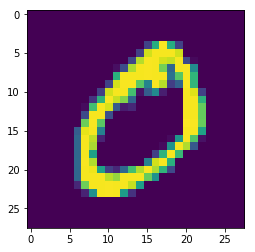

In [27]:
# 謎のエラー
plt.imshow(X_train[np.where(y_train == 0)][0].reshape(imwidth,imheight))

In [28]:
X_train0 = X_train[np.where(y_train == 0)]
X_train1 = X_train[np.where(y_train == 1)]
X_train2 = X_train[np.where(y_train == 2)]
X_train3 = X_train[np.where(y_train == 3)]
X_train4 = X_train[np.where(y_train == 4)]
X_train5 = X_train[np.where(y_train == 5)]
X_train6 = X_train[np.where(y_train == 6)]
X_train7 = X_train[np.where(y_train == 7)]
X_train8 = X_train[np.where(y_train == 8)]
X_train9 = X_train[np.where(y_train == 9)]

In [29]:
# get anchor and positive image　
pair = np.random.randint(0,len(X_train1),2)
anchor = X_train1[pair[0]]
positive = X_train1[pair[1]]

nega_idx = np.random.randint(len(X_train2))
negative = X_train2[nega_idx]

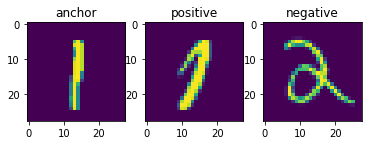

In [30]:
triplet = [anchor, positive, negative]
# method for visualization
def plot_triplet(triplet):
    title = ['anchor','positive','negative']
    for i,t in enumerate(triplet):
        plt.subplot(1,3,i+1)
        plt.imshow(triplet[i].reshape(imwidth, imheight))
        plt.title('{}'.format(title[i]))
    plt.show()
    
plot_triplet(triplet)

## Create Triplets

In [31]:
triplet_num = 2000
triplets = []
mnist_data = [X_train0,X_train1,X_train2,X_train3,X_train4,X_train5,X_train6,X_train7,X_train8,X_train9]
for i in range(len(mnist_data)): # roop for 0~!
    # set the files of anchor and positive images
    pres_mnist = mnist_data[i]
    for iteration in range(triplet_num):
        # set the number of negative images
        j = random.choice([num for num in range(len(mnist_data)) if num not in [i]])
        nega_files = mnist_data[j]

        # get anchor and positive images as numpy array
        pair = np.random.randint(0,len(pres_mnist),2)
        anchor = pres_mnist[pair[0]]
        positive = pres_mnist[pair[1]]
        
        # get negative images as numpy array
        nega_idx = np.random.randint(len(nega_files))
        negative = nega_files[nega_idx]

        # make triplet
        triplet = [anchor, positive, negative]
        
        # (optional)visualization
        # plot_triplet(triplet)
        
        # append with normalization (0,1)
        triplets.append([anchor/255., positive/255., negative/255.])
        
# save triplets as numpy array
triplets = np.array(triplets)
print('save file')
np.save('./mnist_model/mnisTriplets.npy',triplets)

save file


In [32]:
triplets = np.load('./mnist_model/mnisTriplets.npy')
print(triplets.shape)

(20000, 3, 28, 28, 1)


In [33]:
type(triplets)

numpy.ndarray

In [39]:
triplets[:,2].shape

(20000, 28, 28, 1)

In [11]:
triplets = np.load('./mnist_model/mnisTriplets.npy')

# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, batch_size=100) # using batch_size is better
tripletNet.save('./mnist_model/mnisTriplet.h5')

# save partial Network 
embNet_a.save('./mnist_model/mnist_embNet_a2.h5')
embNet_p.save('./mnist_model/mnist_embNet_p2.h5')
embNet_n.save('./mnist_model/mnist_embNet_n2.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  after removing the cwd from sys.path.


Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[100,28,28,32]
	 [[Node: model_2/conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_positive_input_0_2/_271, conv2d_1/kernel/read)]]
	 [[Node: loss_1/add/_311 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1284_loss_1/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'model_2/conv2d_1/convolution', defined at:
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-1d4026b21b96>", line 7, in <module>
    p_emb = embNet_p(p_in)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3189, in conv2d
    data_format=tf_data_format)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,28,28,32]
	 [[Node: model_2/conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_positive_input_0_2/_271, conv2d_1/kernel/read)]]
	 [[Node: loss_1/add/_311 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1284_loss_1/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [12]:
from keras.models import load_model
embNet = load_model('./mnist_model/mnist_embNet_a.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
emb_vecs = np.zeros((len(X_test),10))
# plt.subplots_adjust(wspace=2, hspace=2)
# plt.figure(figsize=(15,15))
for i,x in enumerate(X_test):
#     plt.subplot(1,len(X_test),i+1)
#     plt.imshow(x.reshape(imheight,imwidth))
    x = (x/255.).astype(np.float32)
    emb_vecs[i] = embNet.predict(np.expand_dims(x,axis=0))[0] # need [0] because of expanding dimension -> [[]]
plt.show()

In [17]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

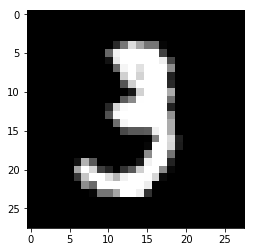

In [34]:
i = 10
test = embNet.predict(np.expand_dims((X_train[i] / 255.).astype(np.float32),axis=0))[0]
plt.imshow(X_train[i].reshape(imwidth,imheight),cmap='gray')

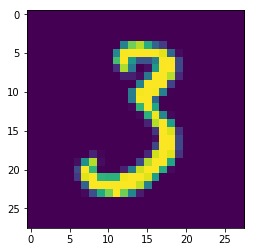

In [28]:
similarities = np.zeros(len(emb_vecs))
for i,emb_vec in enumerate(emb_vecs):
    similarities[i] = distance(test,emb_vec)
min_idx = np.argmin(similarities)
nearest = X_test[min_idx]

plt.imshow(nearest.reshape(imwidth,imheight))

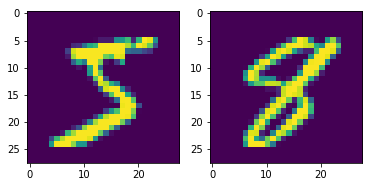

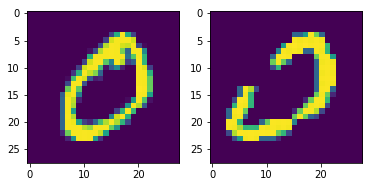

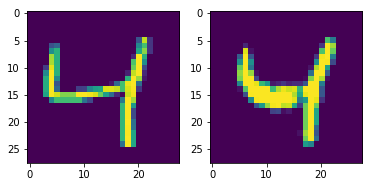

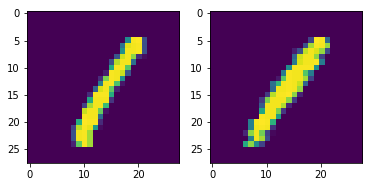

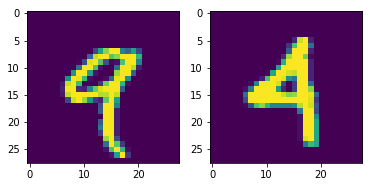

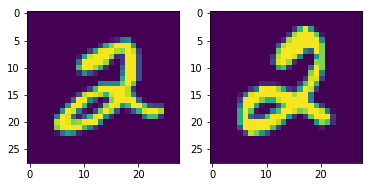

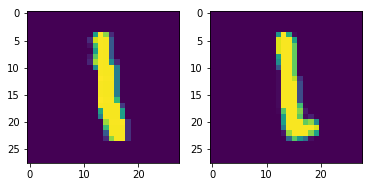

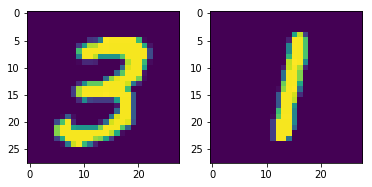

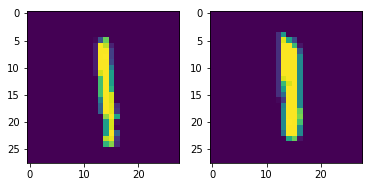

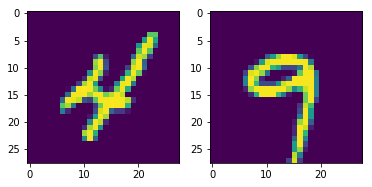

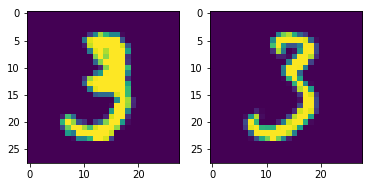

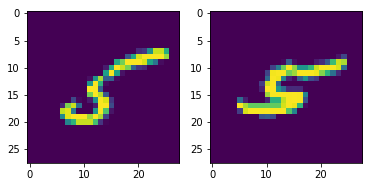

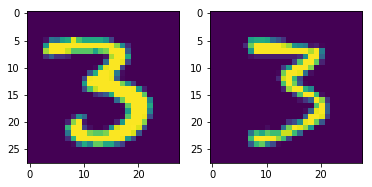

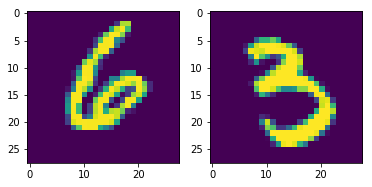

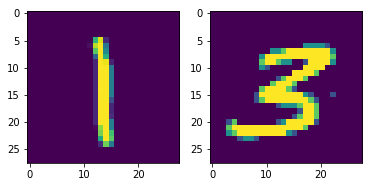

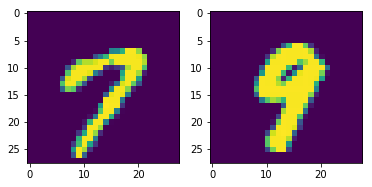

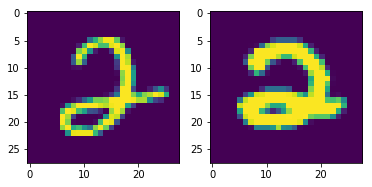

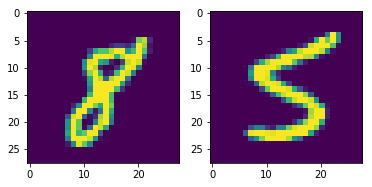

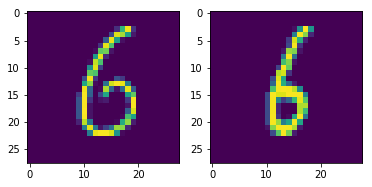

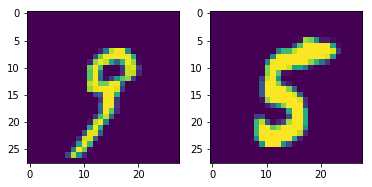

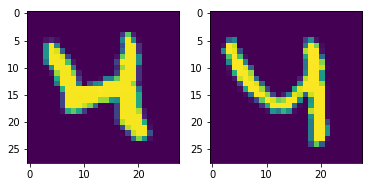

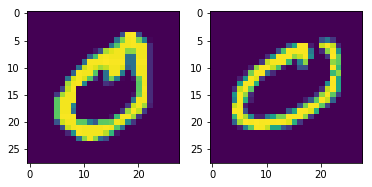

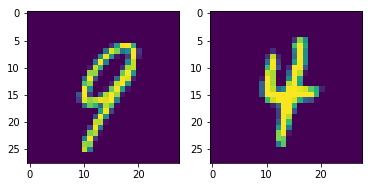

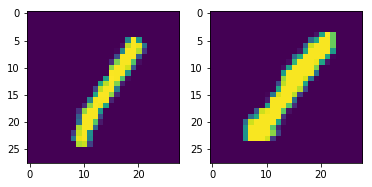

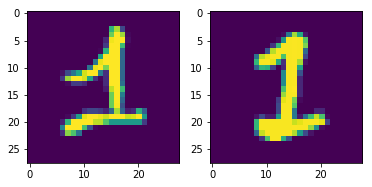

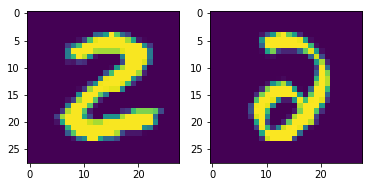

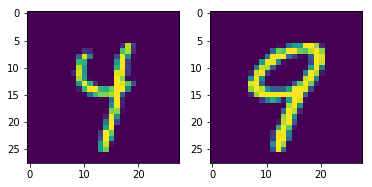

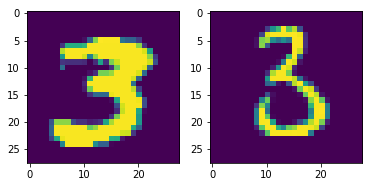

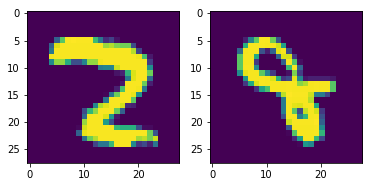

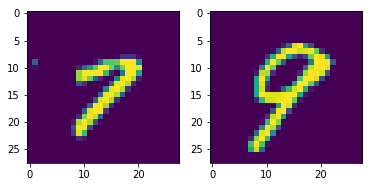

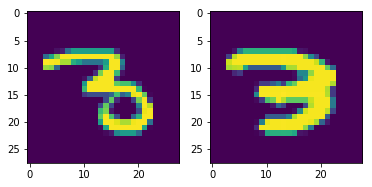

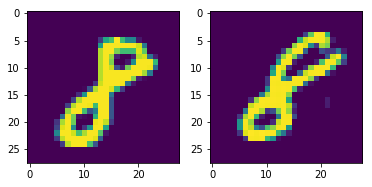

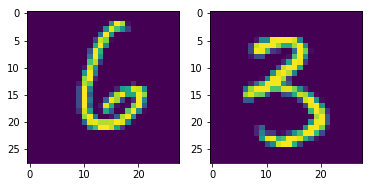

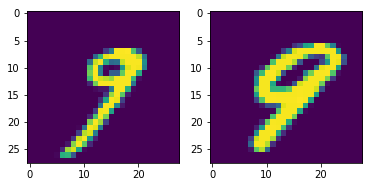

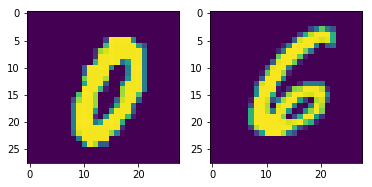

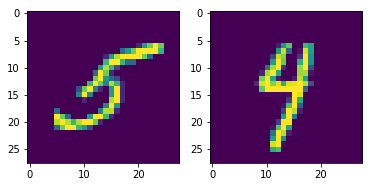

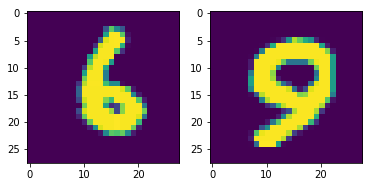

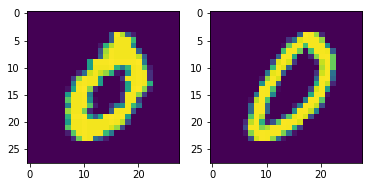

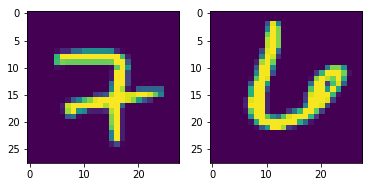

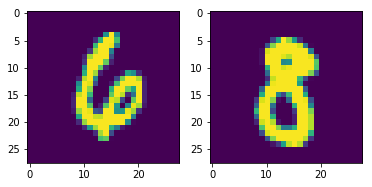

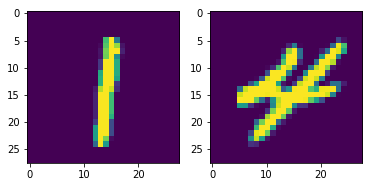

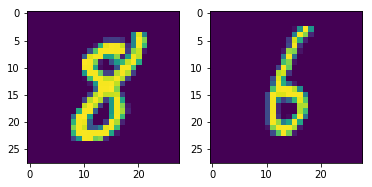

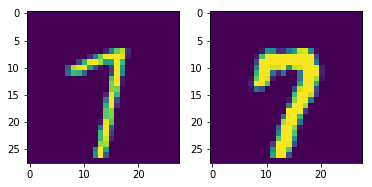

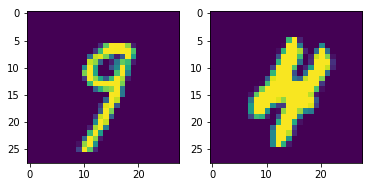

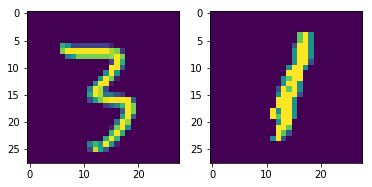

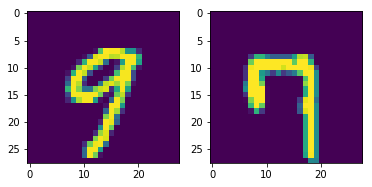

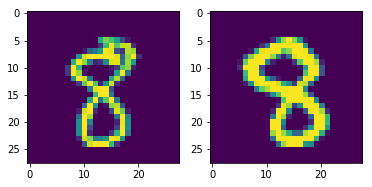

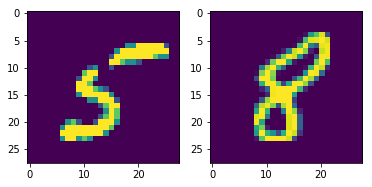

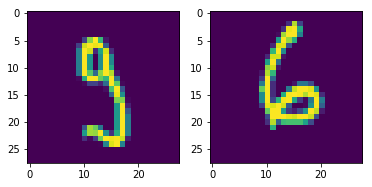

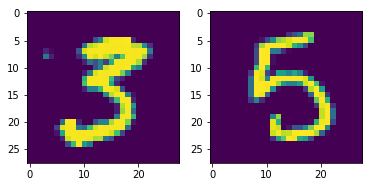

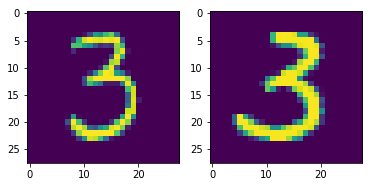

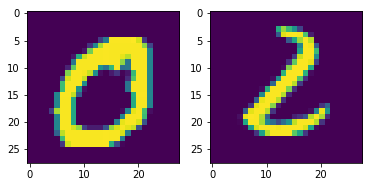

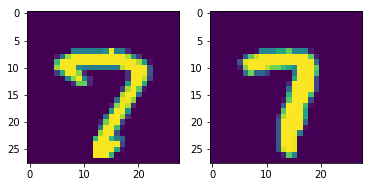

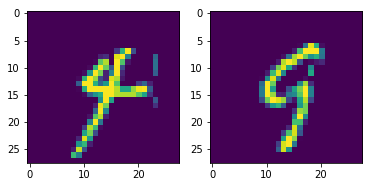

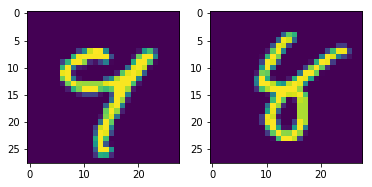

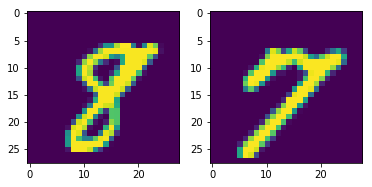

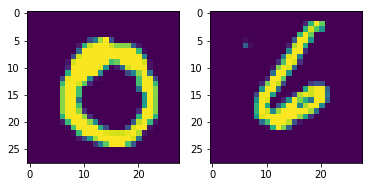

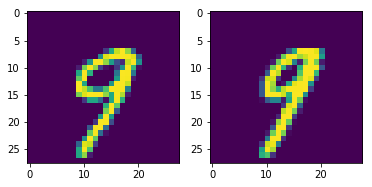

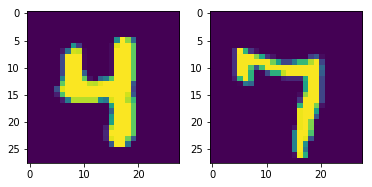

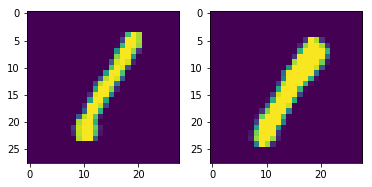

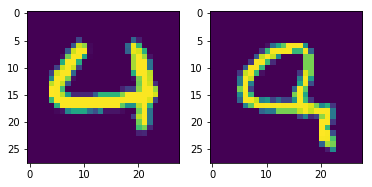

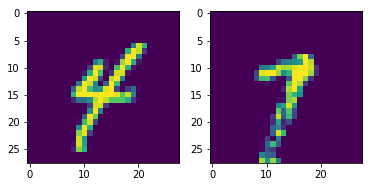

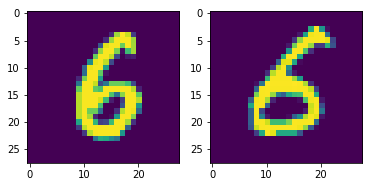

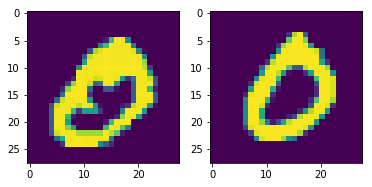

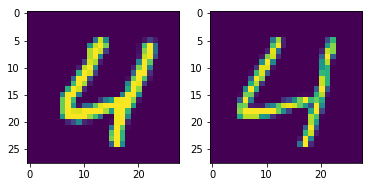

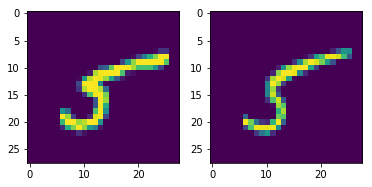

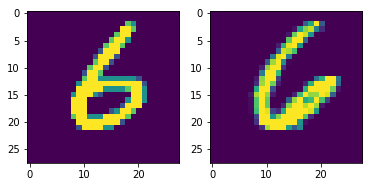

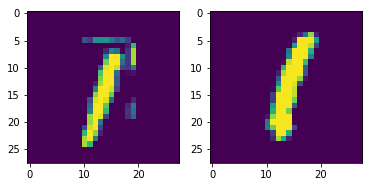

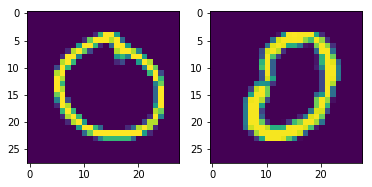

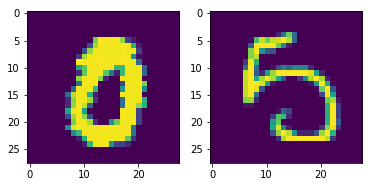

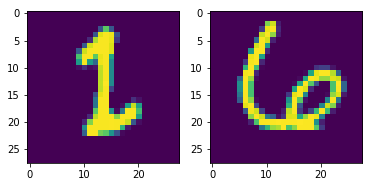

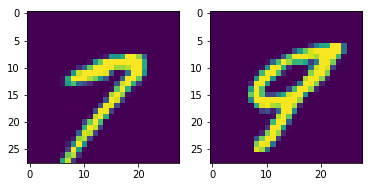

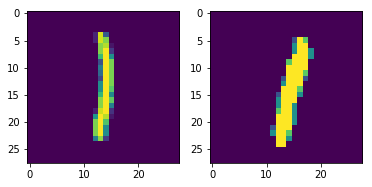

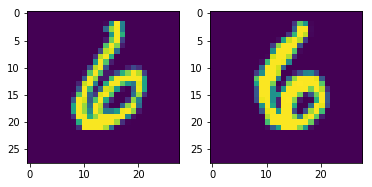

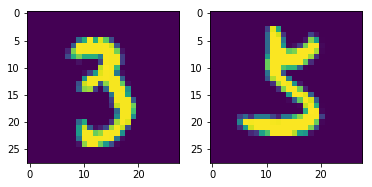

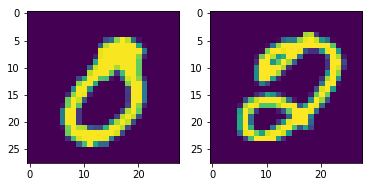

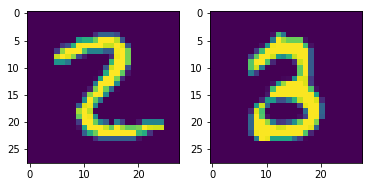

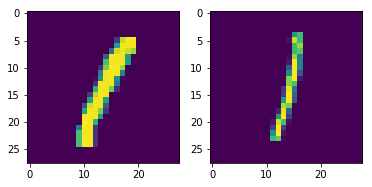

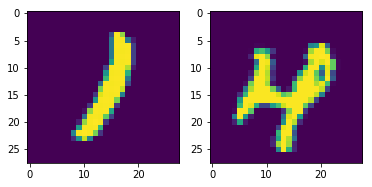

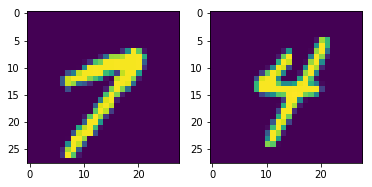

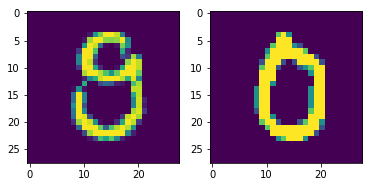

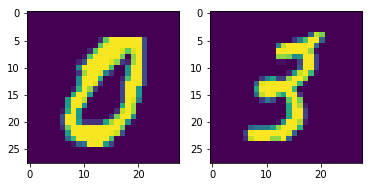

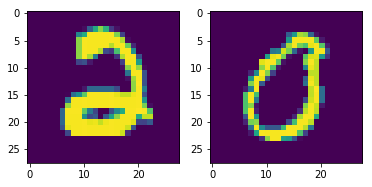

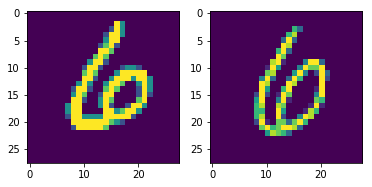

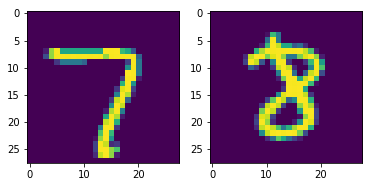

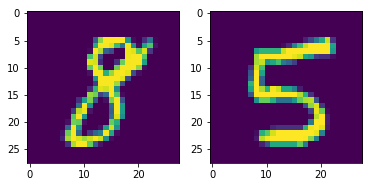

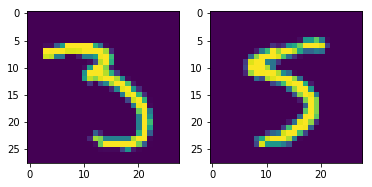

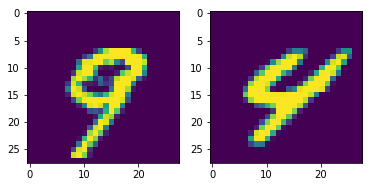

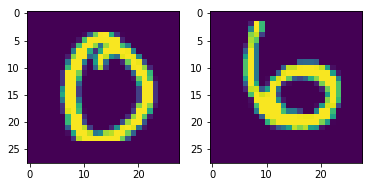

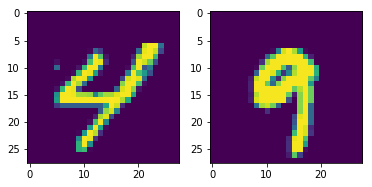

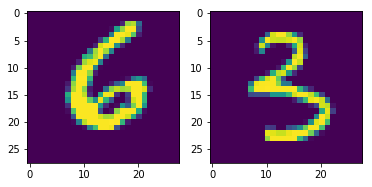

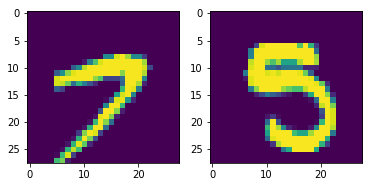

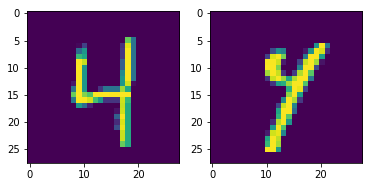

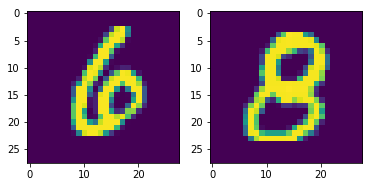

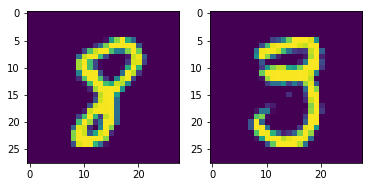

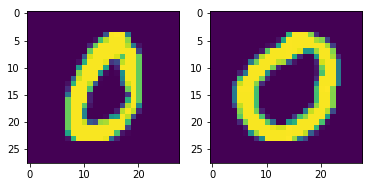

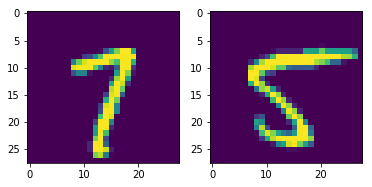

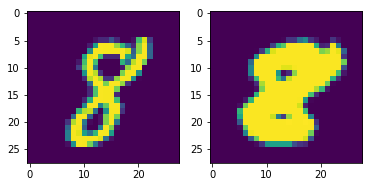

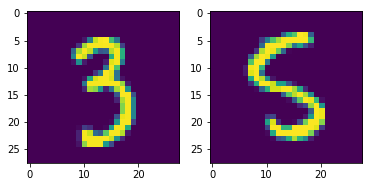

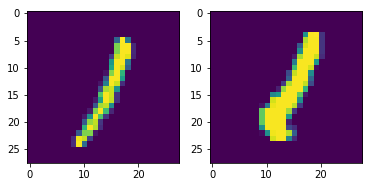

In [32]:
for i in range(100):
    plt.subplot(1,2,1)
    test = embNet.predict(np.expand_dims((X_train[i] / 255.).astype(np.float32),axis=0))[0]
    plt.imshow(X_train[i].reshape(imwidth,imheight))

    plt.subplot(1,2,2)
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec)
    min_idx = np.argmin(similarities)
    nearest = X_test[min_idx]
    plt.imshow(nearest.reshape(imwidth,imheight))  
    plt.show()

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(emb_vecs)
transformed = pca.fit_transform(emb_vecs)

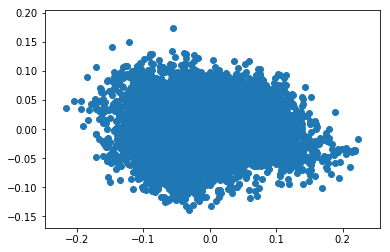

In [45]:
plt.scatter(transformed[:, 0], transformed[:, 1])

In [38]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/inouelab/.conda/envs/keras35/l

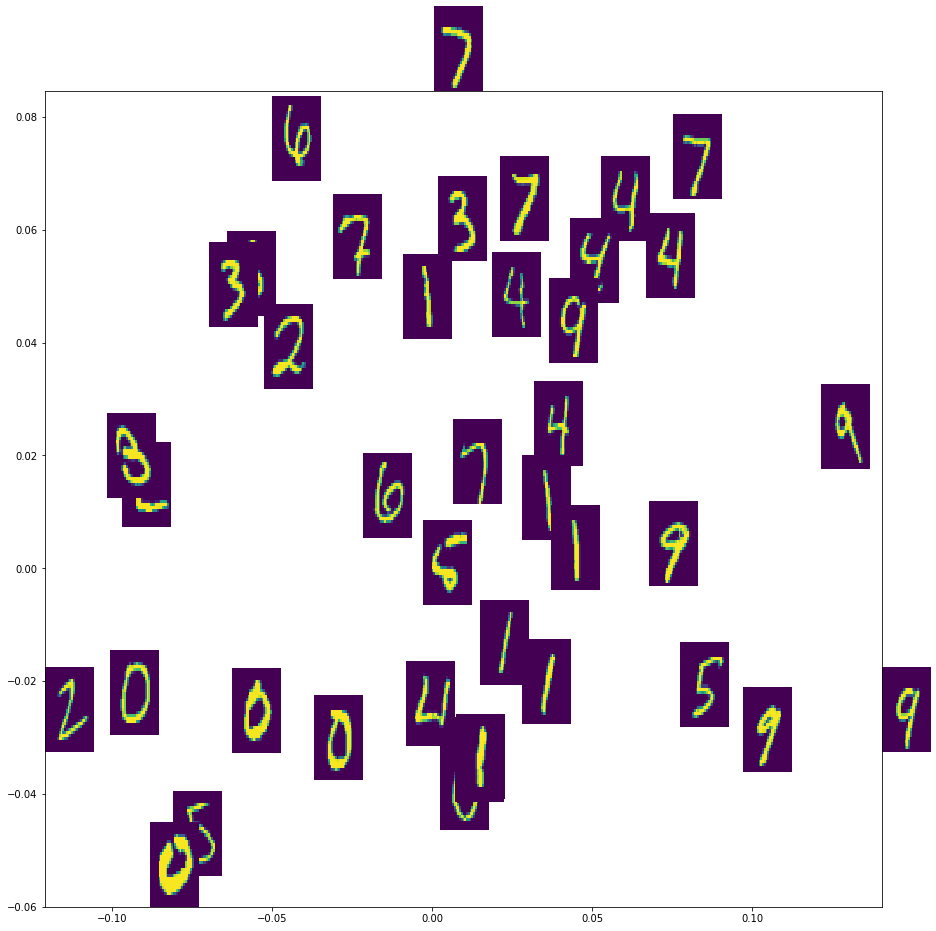

In [76]:
lim = 40

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
xlim = [transformed[:lim,0].min()-10e-10, transformed[:lim,0].max()+10e-10]
ylim = [transformed[:lim,1].min()-10e-10, transformed[:lim,1].max()+10e-10]
i = 0
for (x, y) in zip(transformed[:lim,0],transformed[:lim,1]):
#         img = plt.imread(path)
    bb = Bbox.from_bounds(x, y, 0.015, 0.015)
    bb2 = TransformedBbox(bb, ax.transData)
    bbox_image = BboxImage(bb2, norm=None, origin=None, clip_on=False)
    bbox_image.set_data(X_test[i].reshape(imwidth,imheight))
    ax.add_artist(bbox_image)
    i += 1
ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
plt.savefig('mnist_scatter.png')
plt.show()